## Pulp

In [1]:
import os
from pulp import *
from itertools import product
from PIL import Image
import pytesseract
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import imutils
from imutils import contours
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nums = [*map(str, [*range(1,10)])]
rows = nums
cols = nums
vals = nums

choices = LpVariable.dicts("Choice", (vals, rows, cols), 0, 1, LpInteger)

In [3]:
prob = LpProblem("Судоку", LpMaximize)
prob += 0, "Целевая функция" # Задаётся нулём, так как нас интересует только подбор значения согласно ограничениям

In [4]:
for r, c in product(rows, cols):
    prob += lpSum([choices[v][r][c] for v in vals]) == 1, ""

for v, r in product(vals, rows):
    prob += lpSum([choices[v][r][c] for c in cols]) == 1, ""

for v, c in product(vals, cols):
    prob += lpSum([choices[v][r][c] for r in rows]) == 1, ""

In [5]:
grid = range(3)
subs = [[(rows[3*i+k],cols[3*j+l]) for k,l in product(grid, grid)] for i,j in product(grid, grid)]

for v,b in product(vals, subs):
    prob += lpSum([choices[v][r][c] for (r, c) in b]) == 1, ""

In [6]:
sudoku_map = [["5","1","1"],
              ["6","2","1"],
              ["8","4","1"],
              ["4","5","1"],
              ["7","6","1"],
              ["3","1","2"],
              ["9","3","2"],
              ["6","7","2"],
              ["8","3","3"],
              ["1","2","4"],
              ["8","5","4"],
              ["4","8","4"],
              ["7","1","5"],
              ["9","2","5"],
              ["6","4","5"],
              ["2","6","5"],
              ["1","8","5"],
              ["8","9","5"],
              ["5","2","6"],
              ["3","5","6"],
              ["9","8","6"],
              ["2","7","7"],
              ["6","3","8"],
              ["8","7","8"],
              ["7","9","8"],
              ["3","4","9"],
              ["1","5","9"],
              ["6","6","9"],
              ["5","8","9"]] 

for num in sudoku_map:
    prob += choices[num[0]][num[1]][num[2]] == 1, ""

In [7]:
prob.solve()
print("Status:", LpStatus[prob.status])
print("Solution:")
for r in rows:
    if r == "1" or r == "4" or r == "7":
        print("+-------+-------+-------+")
    for c,v in product(cols,vals):
        if choices[v][r][c].value() == 1:
            if c == "1" or c == "4" or c =="7":
                print("|", end=' ')
            print(v, end=' ')
            if c == "9":
                print("|")
print("+-------+-------+-------+")                    


Status: Optimal
Solution:
+-------+-------+-------+
| 5 3 4 | 6 7 8 | 9 1 2 |
| 6 7 2 | 1 9 5 | 3 4 8 |
| 1 9 8 | 3 4 2 | 5 6 7 |
+-------+-------+-------+
| 8 5 9 | 7 6 1 | 4 2 3 |
| 4 2 6 | 8 5 3 | 7 9 1 |
| 7 1 3 | 9 2 4 | 8 5 6 |
+-------+-------+-------+
| 9 6 1 | 5 3 7 | 2 8 4 |
| 2 8 7 | 4 1 9 | 6 3 5 |
| 3 4 5 | 2 8 6 | 1 7 9 |
+-------+-------+-------+


## OpenCV

In [18]:
def get_perspective(img, location, height = 900, width = 900):

    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def find_board(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None
    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location


def split_boxes(board, input_size):
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size))#/255.0
            boxes.append(box)
    return boxes


In [28]:
img = cv2.imread('examples/7.png')

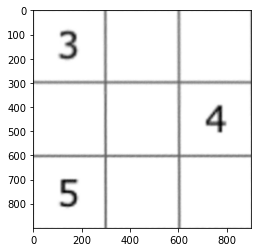

In [58]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
edged = cv2.Canny(bfilter, 30, 180)
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
location = None
# Finds rectangular contour
for contour in contours:
    approx = cv2.approxPolyDP(contour, 15, closed=True)
    if len(approx) == 4:
        location = approx
        break
result = get_perspective(img, location)
plt.imshow(result)

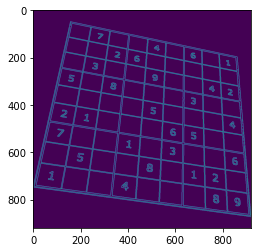

In [63]:
plt.imshow(edged)

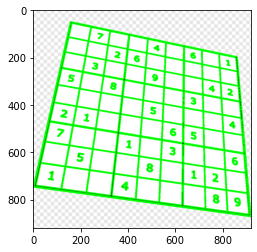

In [30]:
plt.imshow(newimg)

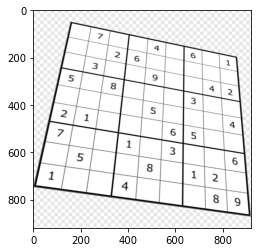

In [31]:
plt.imshow(img)

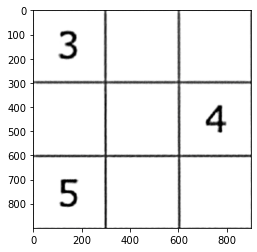

In [32]:
board, location = find_board(img)
input_size = board.shape[:2]
plt.imshow(cv2.detailEnhance(board, sigma_s=10, sigma_r=0.5))

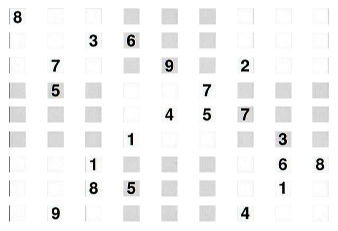

In [24]:
splitted = split_boxes(board, input_size)

fig, ax = plt.subplots(nrows=9, ncols=9)
x = 0
for i in range(9):
    for j in range(9):
        p = splitted[x]
        cutx = p.shape[0]//15
        cuty = p.shape[1]//15
        enchanced = cv2.detailEnhance(p[cutx:p.shape[0]-cutx, cuty:p.shape[1]-cuty], sigma_s=10, sigma_r=0.5)
        bordered = cv2.copyMakeBorder(enchanced, cuty*2, cuty*2, cutx*2, cutx*2, cv2.BORDER_CONSTANT, value=[255,255,255])
        ax[i][j].imshow(bordered)
        ax[i][j].axis('off')
        x += 1

In [25]:
for i in range(len(splitted)):
    p = splitted[i]
    enchanced = cv2.detailEnhance(p[cutx:p.shape[0]-cutx, cuty:p.shape[1]-cuty], sigma_s=10, sigma_r=0.5)
    bordered = cv2.copyMakeBorder(enchanced, cuty*2, cuty*2, cutx*2, cutx*2, cv2.BORDER_CONSTANT, value=[255,255,255])
    cv2.imwrite(fr"C:\Users\lol\Sudoku\sudoku\rec_samples\{i}.png", bordered)

In [26]:
l = os.listdir(r'C:\Users\lol\Sudoku\sudoku\rec_samples')

l = sorted(l, key=len)
res = []
for i in l:
    text = pytesseract.image_to_string(Image.open(fr"C:\Users\lol\Sudoku\sudoku\rec_samples\{i}"), config="--psm 10 digits")
    res.append(text[:text.find('\n')])

res = np.array(res)
res = res.reshape((9,9))
res = pd.DataFrame(res)
res.index = range(1,10)
res.columns = range(1,10)

res

,1,2,3,4,5,6,7,8,9
1,8,,,,,,,,-
2,,,3,6,,,,,
3,,,,,9,,2,,7
4,,,,.,.,,,,
5,,,,,4,,,,
6,,,,1,,4,,3,
7,,,1,,,,,6,
8,,-,,,,,,1,
9,,8,,,,,,,
